In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import zscore
from glob import glob
from itertools import product

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import shapely
from shapely.ops import unary_union
from shapely.geometry import mapping, Polygon
# from src.grid_generation import *

In [2]:
# Month of data to load (unable to read more than one more due to pc memory bandwidth)
YEAR = '2021'
MONTH = '02'
MINUTES_WINDOW_SIZE = '60Min'

In [3]:
#Load data and filter essential columns
data = pd.read_parquet(f"../../data/Tlc-Trip-Record-Data/{YEAR}/yellow_tripdata_{YEAR}-{MONTH}.parquet")
data = data[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'total_amount']]
data

,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,total_amount
0,2021-02-01 00:40:47,2021-02-01 00:48:28,141,226,12.30
1,2021-02-01 00:07:44,2021-02-01 00:20:31,43,263,13.30
2,2021-02-01 00:59:36,2021-02-01 01:24:13,114,263,22.80
3,2021-02-01 00:03:26,2021-02-01 00:16:32,236,229,17.76
4,2021-02-01 00:20:20,2021-02-01 00:24:03,229,140,9.96
...,...,...,...,...,...
1371704,2021-02-28 23:02:08,2021-02-28 23:02:02,265,3,43.35
1371705,2021-02-28 23:27:00,2021-02-28 23:41:00,68,24,24.77
1371706,2021-02-28 23:18:05,2021-02-28 23:26:48,68,137,15.40
1371707,2021-02-28 23:41:07,2021-03-01 00:13:44,113,254,62.70


In [4]:
# Join gdf geometry to data according to PULocationID
manhattan_gdf = gpd.read_file('../../data/new_data/taxi_zones/taxi_zones.shp')
manhattan_gdf = manhattan_gdf[manhattan_gdf.borough == 'Manhattan']

manhattan_gdf["PULocationID"] = manhattan_gdf.LocationID
data = manhattan_gdf.merge(data, on='PULocationID', how='inner')

In [5]:
# Change pickup and dropoff datetime to datetime format
data.tpep_pickup_datetime = pd.to_datetime(data["tpep_pickup_datetime"])
data.tpep_dropoff_datetime = pd.to_datetime(data["tpep_dropoff_datetime"])

In [6]:
# Extract year & month
data["y_m"] = pd.to_datetime(data["tpep_pickup_datetime"]).dt.strftime('%Y-%m')

In [7]:
# Filter date
mask = (data['y_m'] >= data['y_m'].head(1).values[0]) & (data['y_m'] <= data['y_m'].tail(1).values[0])
data = data.loc[mask]

In [8]:
# Get date only
data["y_m_d"] = pd.to_datetime(data["tpep_pickup_datetime"]).dt.strftime('%Y-%m-%d')

In [9]:
# Extract hour of a day for PU (12AM = 0, 11PM = 23)
data["hour"] = data.tpep_pickup_datetime.dt.hour

In [10]:
# Label rows according to 15 mins window
data["mins"] = data.tpep_pickup_datetime.dt.floor(MINUTES_WINDOW_SIZE).dt.minute

In [11]:
# Concat PULocationID with DOLocation
data['p2p'] = data[["PULocationID", "DOLocationID"]].astype(str).agg('_'.join, axis=1)

In [12]:
data

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,tpep_pickup_datetime,tpep_dropoff_datetime,DOLocationID,total_amount,y_m,y_m_d,hour,mins,p2p
0,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,2021-02-01 04:18:58,2021-02-01 04:37:41,114,15.30,2021-02,2021-02-01,4,0,4_114
1,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,2021-02-01 15:05:27,2021-02-01 15:21:34,164,19.56,2021-02,2021-02-01,15,0,4_164
2,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,2021-02-01 18:54:49,2021-02-01 19:01:32,232,10.80,2021-02,2021-02-01,18,0,4_232
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,2021-02-01 21:22:16,2021-02-01 21:37:32,112,21.30,2021-02,2021-02-01,21,0,4_112
4,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,2021-02-02 09:40:29,2021-02-02 09:47:26,113,12.25,2021-02,2021-02-02,9,0,4_113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247168,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,2021-02-28 15:38:30,2021-02-28 15:49:02,141,16.57,2021-02,2021-02-28,15,0,263_141
1247169,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,2021-02-28 17:02:40,2021-02-28 17:14:24,48,16.45,2021-02,2021-02-28,17,0,263_48
1247170,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,2021-02-28 17:02:23,2021-02-28 17:20:47,79,35.74,2021-02,2021-02-28,17,0,263_79
1247171,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,2021-02-28 21:17:50,2021-02-28 21:23:32,262,12.09,2021-02,2021-02-28,21,0,263_262


In [13]:
a = data['PULocationID'].unique()
print(len(a))

66


In [14]:
# Merge the grid ids of data to the grid geoPandas dataframe
pu_count = pd.DataFrame()
pu_count['count'] = data.groupby(['PULocationID', 'y_m_d', 'hour', 'mins']).size()
pu_count['ave_total_amount'] = data.groupby(['PULocationID', 'y_m_d', 'hour', 'mins'])['total_amount'].agg(['mean'])
pu_count['LocationID'] = pu_count.index.get_level_values('PULocationID')
pu_count['y_m_d'] = pu_count.index.get_level_values('y_m_d')
pu_count['hour'] = pu_count.index.get_level_values('hour')
pu_count['mins'] = pu_count.index.get_level_values('mins')
pu_count['time_slot'] = pd.to_datetime(pu_count['y_m_d'] + ' ' + pu_count['hour'].astype(str) + ':' + pu_count['mins'].astype(str))
pu_count = manhattan_gdf.merge(pu_count, on='PULocationID', how='inner')

In [15]:
pu_count

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID_x,borough,geometry,PULocationID,count,ave_total_amount,LocationID_y,y_m_d,hour,mins,time_slot
0,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,1,15.300000,4,2021-02-01,4,0,2021-02-01 04:00:00
1,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,2,21.275000,4,2021-02-01,6,0,2021-02-01 06:00:00
2,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,1,20.140000,4,2021-02-01,14,0,2021-02-01 14:00:00
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,1,19.560000,4,2021-02-01,15,0,2021-02-01 15:00:00
4,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4,1,10.800000,4,2021-02-01,18,0,2021-02-01 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35918,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,49,14.285306,263,2021-02-28,19,0,2021-02-28 19:00:00
35919,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,41,12.346098,263,2021-02-28,20,0,2021-02-28 20:00:00
35920,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,33,13.508788,263,2021-02-28,21,0,2021-02-28 21:00:00
35921,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.323 220912.386, 997355.264 22...",263,27,15.545926,263,2021-02-28,22,0,2021-02-28 22:00:00


In [16]:
# Pivot table
pu_count_table = pu_count.pivot_table(index="time_slot", columns="PULocationID", values="count")
pu_count_table.reset_index().rename_axis(None, axis=1)
pu_count_table = pu_count_table.fillna(0)
pu_count_table.sort_values(by='time_slot', inplace = True) 

In [17]:
pu_count_table

PULocationID,4,12,13,24,41,42,43,45,48,50,...,237,238,239,243,244,246,249,261,262,263
time_slot,,,,,,,,,,,,,,,,,,,,,
2021-02-01 00:00:00,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,9.0,1.0,...,1.0,2.0,5.0,0.0,2.0,1.0,4.0,0.0,1.0,5.0
2021-02-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,2.0,4.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0
2021-02-01 02:00:00,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,3.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2021-02-01 03:00:00,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2021-02-01 04:00:00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,4.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 19:00:00,2.0,0.0,2.0,4.0,12.0,5.0,30.0,5.0,67.0,8.0,...,77.0,53.0,62.0,1.0,2.0,32.0,42.0,4.0,25.0,49.0
2021-02-28 20:00:00,0.0,0.0,0.0,2.0,5.0,7.0,9.0,1.0,51.0,11.0,...,55.0,32.0,41.0,1.0,4.0,6.0,42.0,4.0,22.0,41.0
2021-02-28 21:00:00,1.0,0.0,2.0,5.0,6.0,4.0,4.0,2.0,39.0,9.0,...,49.0,22.0,24.0,1.0,2.0,7.0,21.0,1.0,11.0,33.0


In [18]:
pu_count_table.to_csv(f'../../Time_Series_CSVs/1h_{YEAR}/{YEAR}_{MONTH}_Time_Series.csv', index=True, header=True)

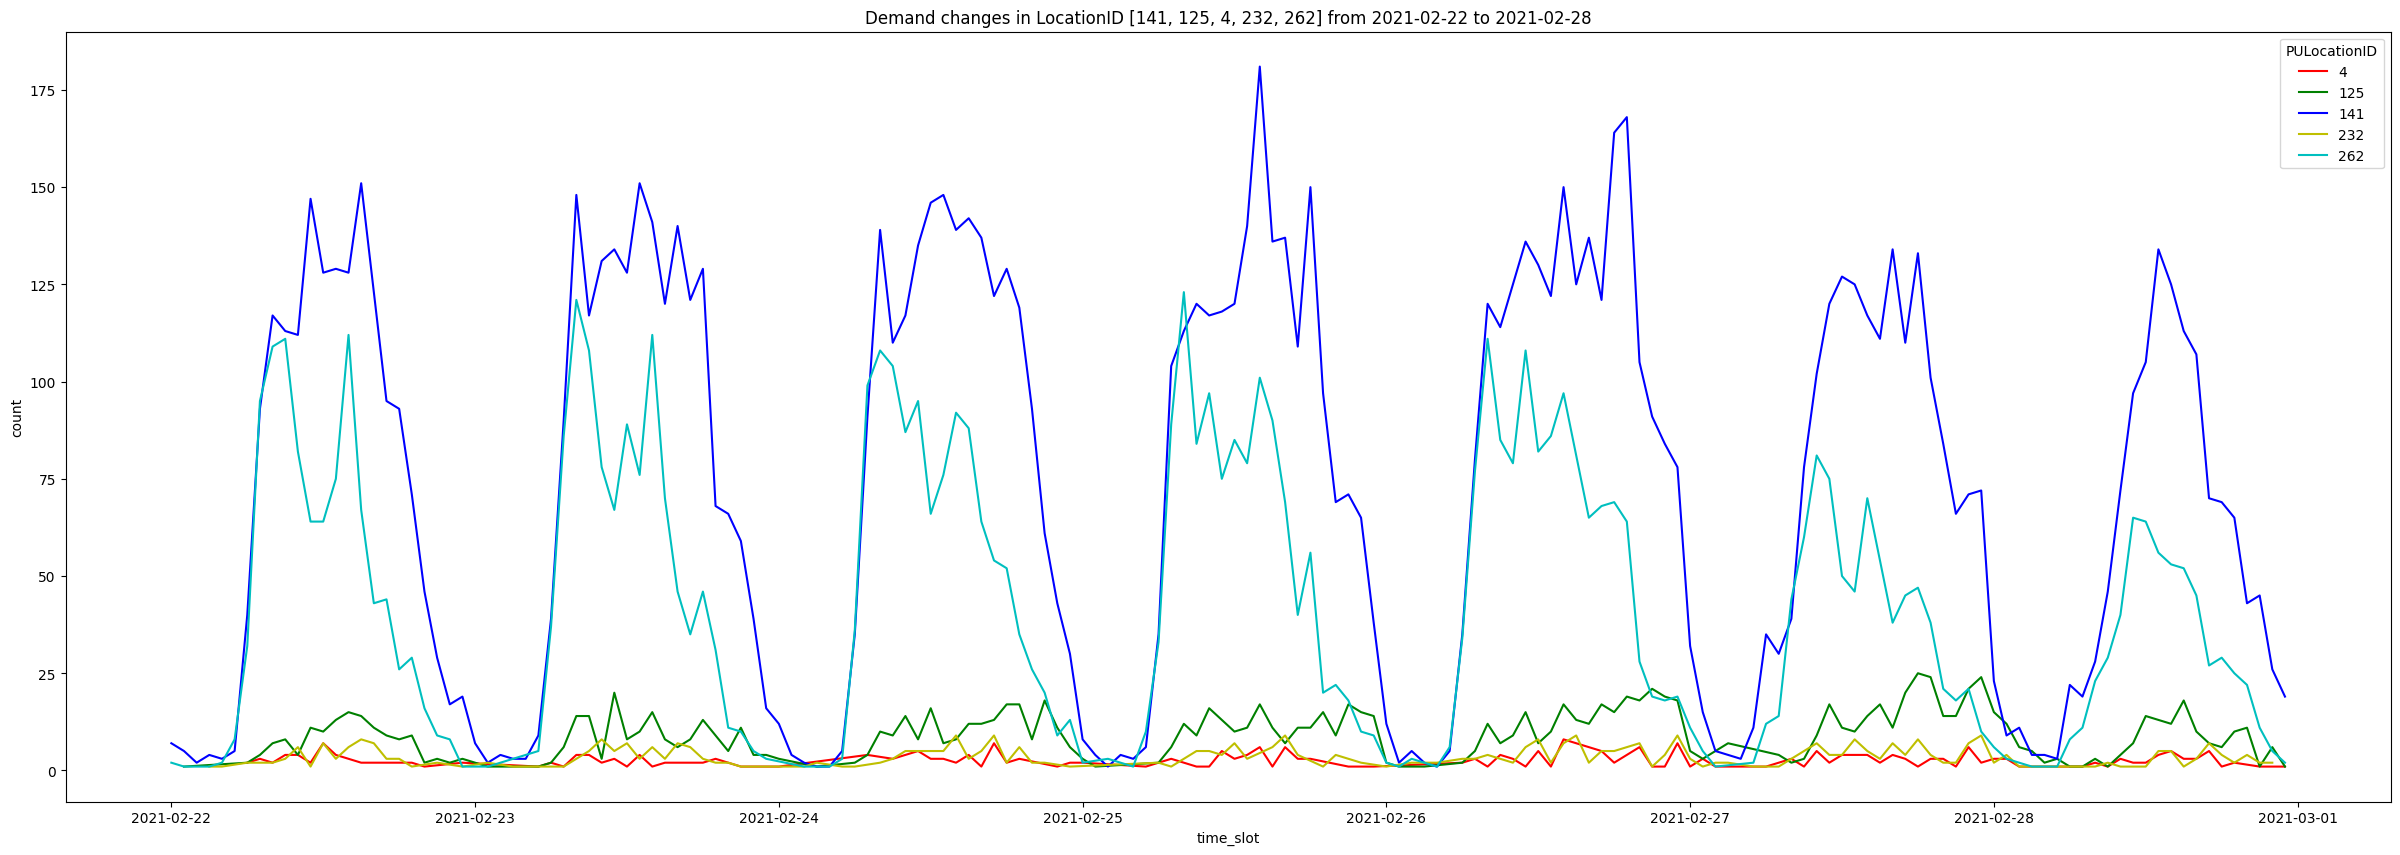

In [19]:
# Plot demand changes of 5 randomly selected regions across 7 days
days_of_data = 7
pu_count.sort_values(by='time_slot', ascending = False, inplace = True)
date_range = [x for x in pd.to_datetime(pu_count.y_m_d).dt.strftime('%Y-%m-%d').unique()[:days_of_data]]

pu_count_gr_7days = pu_count.loc[(pd.to_datetime(pu_count.y_m_d)).isin(date_range)]
rand_loc = list(pu_count_gr_7days.PULocationID.sample(n=5, random_state=1))
pu_count_gr_7days = pu_count_gr_7days.loc[pu_count_gr_7days.PULocationID.isin(rand_loc)]

fig, ax = plt.subplots(figsize=(30, 10))
ax.set_title(f"Demand changes in LocationID {rand_loc} from {pu_count_gr_7days.y_m_d.iloc[-1]} to {pu_count_gr_7days.y_m_d.iloc[0]}")
pu_plot_7 = sns.lineplot(ax=ax, data=pu_count_gr_7days,  x="time_slot", y="count", hue="PULocationID", palette=['r', 'g', 'b', 'y', 'c'])

In [20]:
PULocationIDFeatures = pd.DataFrame()

PULocationIDFeatures['ave_total_amount'] = pu_count.groupby(['PULocationID'])['ave_total_amount'].agg(['mean'])

PULocationIDFeatures

,ave_total_amount
PULocationID,
4,22.766224
12,22.502248
13,22.782451
24,15.454274
41,14.809172
...,...
246,17.909468
249,16.159053
261,22.246773


In [21]:
zone_features1 = pd.read_csv('../../zone_features.csv')
PULocationIDFeatures2 = pd.merge(PULocationIDFeatures, zone_features1, on='PULocationID', how="inner")
PULocationIDFeatures2

,PULocationID,ave_total_amount,zone,school,school_school,school_primary_school,school_secondary_school,school_university,food,food_bar,...,adhoc_store,adhoc_storage,adhoc_travel_agency,adhoc_veterinary_care,religious,religious_church,religious_cemetery,religious_hindu_temple,religious_mosque,religious_synagogue
0,4,22.766224,Alphabet City,0,0,0,0,0,1,1,...,1,0,0,0,1,1,0,0,0,0
1,12,22.502248,Battery Park,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13,22.782451,Battery Park City,1,1,0,0,0,1,1,...,1,0,0,0,1,1,0,0,0,0
3,24,15.454274,Bloomingdale,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,41,14.809172,Central Harlem,1,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,246,17.909468,West Chelsea/Hudson Yards,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,249,16.159053,West Village,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
63,261,22.246773,World Trade Center,1,1,0,1,0,1,1,...,1,0,0,0,0,0,0,0,0,0
64,262,16.300912,Yorkville East,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0


<Axes: ylabel='Density'>

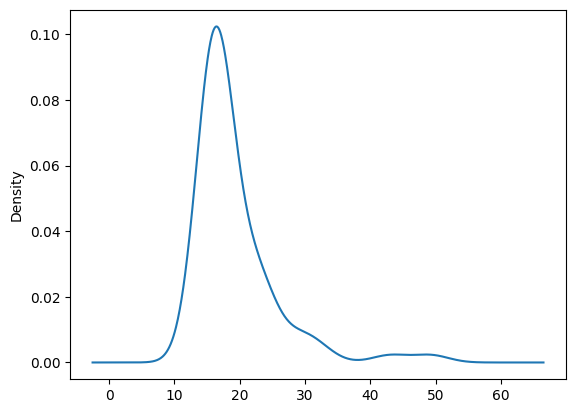

In [22]:
PULocationIDFeatures2['ave_total_amount'].plot(kind='kde')

In [23]:
a = pd.read_csv(f'../../Time_Series_CSVs/{YEAR}/{YEAR}_{MONTH}_Time_Series.csv')
a

,time_slot,4,12,13,24,41,42,43,45,48,...,237,238,239,243,244,246,249,261,262,263
0,2021-02-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0
1,2021-02-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0,1.0,3.0
2,2021-02-01 00:30:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2021-02-01 00:45:00,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2021-02-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683,2021-02-28 22:45:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,...,7.0,3.0,4.0,0.0,1.0,1.0,4.0,0.0,2.0,4.0
2684,2021-02-28 23:00:00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,14.0,...,7.0,2.0,7.0,0.0,0.0,0.0,4.0,1.0,0.0,8.0
2685,2021-02-28 23:15:00,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,10.0,...,3.0,6.0,5.0,0.0,1.0,0.0,6.0,0.0,2.0,4.0
2686,2021-02-28 23:30:00,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,6.0,...,2.0,5.0,6.0,0.0,0.0,0.0,7.0,1.0,0.0,3.0


### Covariate time series for average total fair for each timestamp

In [24]:
pu_ave_total_fair_table = pu_count.pivot_table(index="time_slot", columns="PULocationID", values="ave_total_amount")
pu_ave_total_fair_table.reset_index().rename_axis(None, axis=1)
pu_ave_total_fair_table = pu_ave_total_fair_table.fillna(0)
pu_ave_total_fair_table.sort_values(by='time_slot', inplace = True) 
pu_ave_total_fair_table

PULocationID,4,12,13,24,41,42,43,45,48,50,...,237,238,239,243,244,246,249,261,262,263
time_slot,,,,,,,,,,,,,,,,,,,,,
2021-02-01 00:00:00,0.00,0.00,0.000,6.800,19.370000,0.000000,13.300000,0.000,18.867778,19.220000,...,8.800000,16.780000,17.568000,0.00,18.620,16.300000,22.205000,0.000000,6.800000,25.464000
2021-02-01 01:00:00,0.00,0.00,0.000,0.000,0.000000,0.000000,0.000000,0.000,26.281429,0.000000,...,15.625000,7.275000,6.666667,42.80,0.000,0.000000,66.360000,0.000000,23.300000,9.825000
2021-02-01 02:00:00,0.00,0.00,0.000,0.000,0.000000,16.773333,0.000000,13.300,19.456667,0.000000,...,0.000000,0.000000,27.300000,0.00,0.000,12.300000,0.000000,0.000000,0.000000,8.760000
2021-02-01 03:00:00,0.00,0.00,0.000,0.000,5.300000,13.800000,12.250000,0.000,36.960000,0.000000,...,0.000000,17.800000,0.000000,0.00,0.000,70.050000,15.300000,0.000000,0.000000,0.000000
2021-02-01 04:00:00,15.30,0.00,0.000,17.300,0.000000,0.000000,0.000000,0.000,0.000000,21.300000,...,12.303333,43.362500,0.000000,0.00,17.800,0.000000,0.500000,0.000000,20.360000,18.702000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 19:00:00,18.16,0.00,25.255,12.840,15.921667,22.860000,11.716667,20.304,14.481045,14.495000,...,13.689481,13.669245,14.335323,31.11,24.140,20.152188,13.539048,17.782500,14.483600,14.285306
2021-02-28 20:00:00,0.00,0.00,0.000,11.150,18.928000,23.381429,14.482222,22.800,15.532353,15.204545,...,13.116364,14.831563,14.162683,18.80,28.165,16.208333,19.180952,14.115000,13.932727,12.346098
2021-02-28 21:00:00,41.80,0.00,48.965,10.682,10.066667,15.992500,12.350000,50.900,13.827949,22.506667,...,13.372857,17.671818,14.710417,17.95,19.980,17.550000,15.890476,9.360000,15.316364,13.508788


In [25]:
pu_ave_total_fair_table.to_csv(f'../../Time_Series_Ave_Total_Fair_CSVs/1h_{YEAR}/{YEAR}_{MONTH}_Time_Series.csv', index=True, header=True)

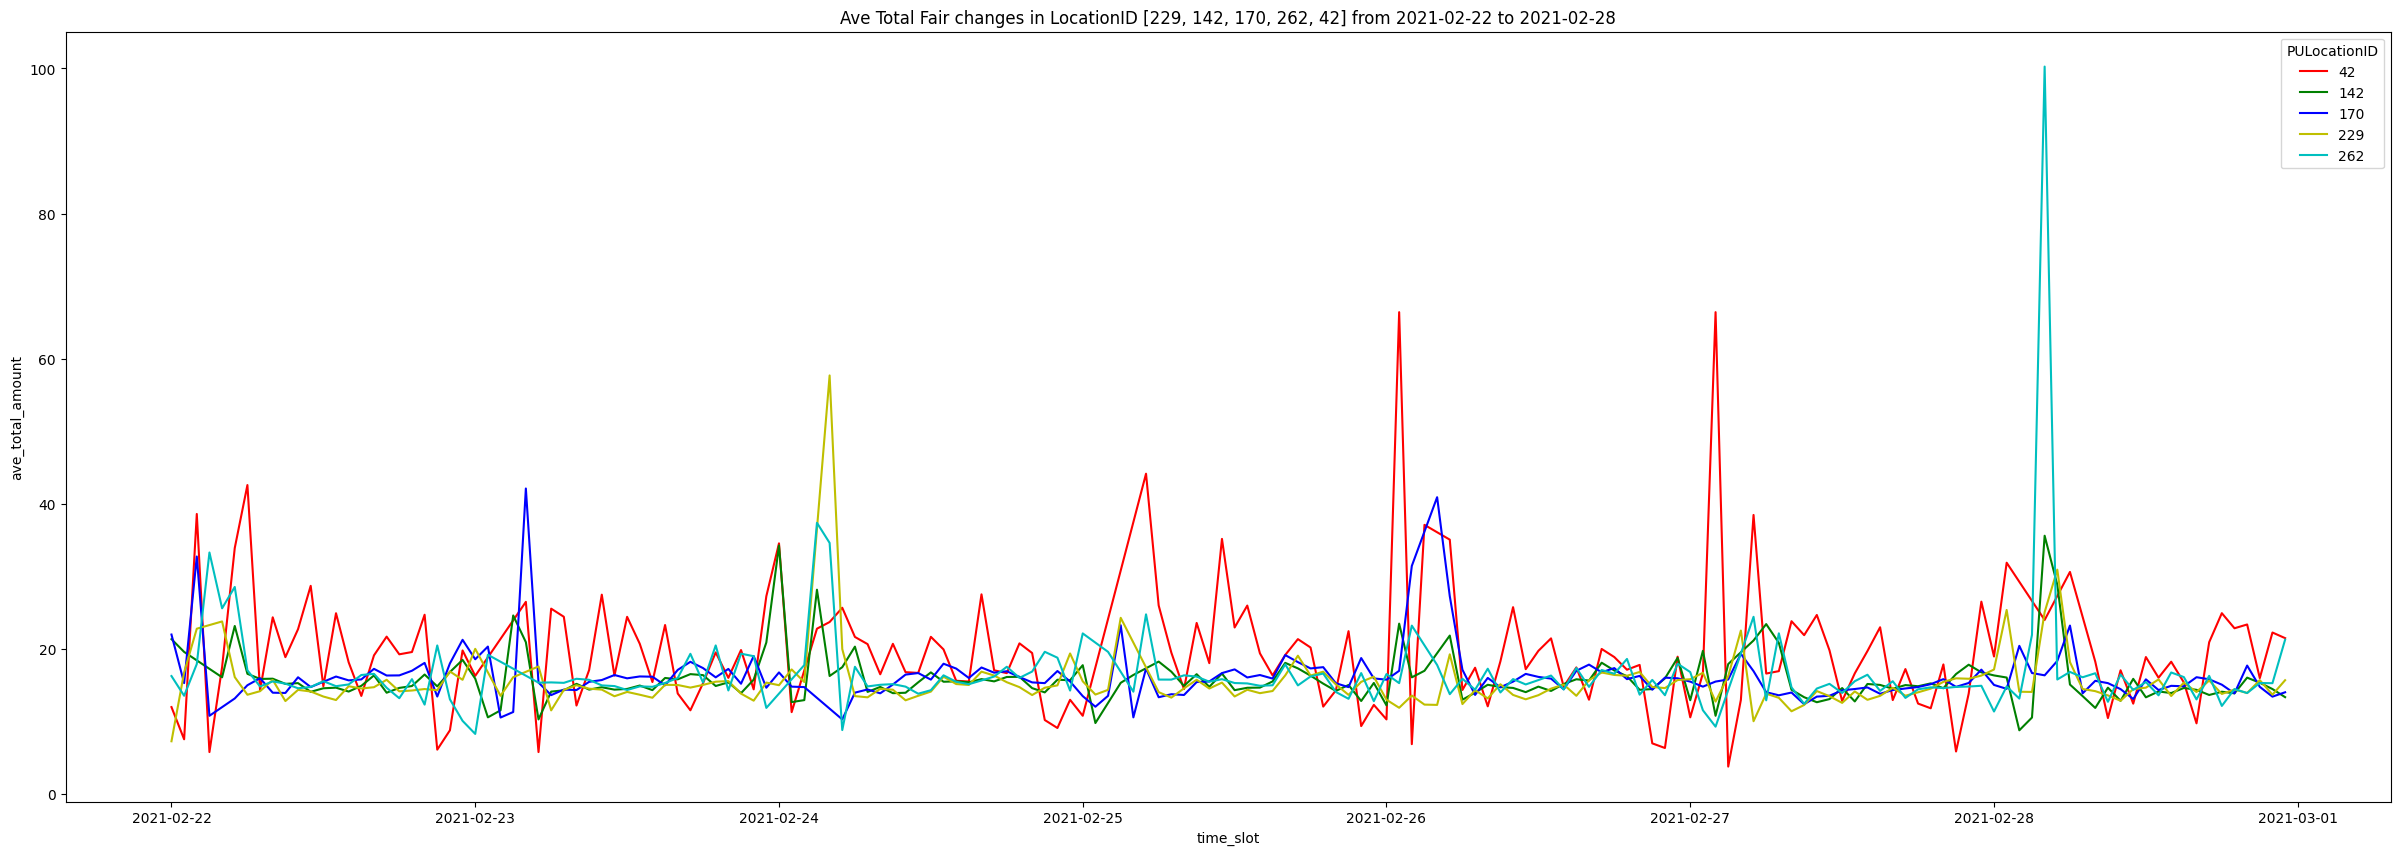

In [26]:
# Plot ave toral amount changes of 5 randomly selected regions across 7 days
days_of_data = 7
pu_count.sort_values(by='time_slot', ascending = False, inplace = True)
date_range = [x for x in pd.to_datetime(pu_count.y_m_d).dt.strftime('%Y-%m-%d').unique()[:days_of_data]]

pu_count_gr_7days = pu_count.loc[(pd.to_datetime(pu_count.y_m_d)).isin(date_range)]
rand_loc = list(pu_count_gr_7days.PULocationID.sample(n=5, random_state=1))
pu_count_gr_7days = pu_count_gr_7days.loc[pu_count_gr_7days.PULocationID.isin(rand_loc)]

fig, ax = plt.subplots(figsize=(30, 10))
ax.set_title(f"Ave Total Fair changes in LocationID {rand_loc} from {pu_count_gr_7days.y_m_d.iloc[-1]} to {pu_count_gr_7days.y_m_d.iloc[0]}")
pu_plot_7 = sns.lineplot(ax=ax, data=pu_count_gr_7days,  x="time_slot", y="ave_total_amount", hue="PULocationID", palette=['r', 'g', 'b', 'y', 'c'])